# ResNet-18 U-net


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -q arnaud58/landscape-pictures
!mkdir -p train
!unzip -q landscape-pictures.zip -d train

Dataset URL: https://www.kaggle.com/datasets/arnaud58/landscape-pictures
License(s): CC0-1.0


In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.color import rgb2lab, lab2rgb
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import time
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

In [ ]:
DATASET_PATH = "train"
IMG_SIZE = 512
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 30

In [ ]:
transforms_pipeline = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.1, hue=0.05),
    transforms.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.5, 1.0), ratio=(0.75, 1.33)),
])

In [ ]:
class NatureColorizationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        extensions = ['*.jpg', '*.jpeg', '*.png', '*.JPG']
        for ext in extensions:
            self.image_paths.extend(glob.glob(os.path.join(root_dir, ext)))
        print(f"Total images loaded: {len(self.image_paths)}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        img_np = np.array(img)
        img_lab = rgb2lab(img_np).astype("float32")

        L = img_lab[:, :, 0] / 100.0
        ab = img_lab[:, :, 1:] / 128.0

        L = torch.from_numpy(L).unsqueeze(0)
        ab = torch.from_numpy(ab.transpose((2, 0, 1)))

        return L, ab

In [ ]:
full_dataset = NatureColorizationDataset(root_dir=DATASET_PATH, transform=transforms_pipeline)
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size
train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=8, shuffle=True)
print(f"{len(train_set)} Train, {len(val_set)} Val, {len(test_set)} Test")

Total images loaded: 4319
3455 Train, 431 Val, 433 Test


In [ ]:
class ResNetColorizer(nn.Module):
    def __init__(self, n_output=2):
        super(ResNetColorizer, self).__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        self.encoder0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)
        self.encoder1 = nn.Sequential(resnet.maxpool, resnet.layer1)  # 64 channels
        self.encoder2 = resnet.layer2  # 128 channels
        self.encoder3 = resnet.layer3  # 256 channels
        self.encoder4 = resnet.layer4  # 512 channels

        self.up1 = self._upsample_conv(512, 256)
        self.conv1 = self._double_conv(256 + 256, 256)

        self.up2 = self._upsample_conv(256, 128)
        self.conv2 = self._double_conv(128 + 128, 128)

        self.up3 = self._upsample_conv(128, 64)
        self.conv3 = self._double_conv(64 + 64, 64)

        self.up4 = self._upsample_conv(64, 64)
        self.conv4 = self._double_conv(64 + 64, 64)

        self.final = nn.Sequential(
            nn.Conv2d(64, n_output, kernel_size=1),
            nn.Tanh()
        )

    def _upsample_conv(self, in_c, out_c):
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def _double_conv(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x_input = x.repeat(1, 3, 1, 1)

        e0 = self.encoder0(x_input) # 1/2
        e1 = self.encoder1(e0) # 1/4
        e2 = self.encoder2(e1) # 1/8
        e3 = self.encoder3(e2) # 1/16
        e4 = self.encoder4(e3) # 1/32

        d1 = self.up1(e4)
        d1 = torch.cat([d1, e3], dim=1)
        d1 = self.conv1(d1)

        d2 = self.up2(d1)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.conv2(d2)

        d3 = self.up3(d2)
        d3 = torch.cat([d3, e1], dim=1)
        d3 = self.conv3(d3)

        d4 = self.up4(d3)
        d4 = torch.cat([d4, e0], dim=1)
        d4 = self.conv4(d4)

        out = self.final(d4)
        out = F.interpolate(out, size=x.shape[2:], mode='bilinear', align_corners=True)
        return out

In [ ]:
def chrominance_weighted_l1_loss(pred, target):
    # Standard L1 loss (per-pixel)
    l1_loss = F.l1_loss(pred, target, reduction='none')

    # chrominance magnitude: sqrt(a^2 + b^2)
    target_magnitude = torch.norm(target, dim=1, keepdim=True)  # (B, 1, H, W)

    # Weight map: baseline weight 1.0 + scaled magnitude
    # Pixels with no color (magnitude=0) get weight 1.0
    # Pixels with max color (magnitude≈1.0) get weight 3.0
    weights = 1.0 + target_magnitude * 2.0

    # Expand weights to match loss channels
    weights = weights.expand_as(l1_loss)

    # Weighted mean
    return (l1_loss * weights).mean()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetColorizer().to(device)

criterion = chrominance_weighted_l1_loss

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

In [ ]:
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, leave=True)

    for L, ab in loop:
        L, ab = L.to(device), ab.to(device)

        optimizer.zero_grad()
        outputs = model(L)

        loss = criterion(outputs, ab)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item()
        loop.set_description(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
        loop.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for L, ab in val_loader:
            L, ab = L.to(device), ab.to(device)
            outputs = model(L)
            loss = F.l1_loss(outputs, ab)
            val_running_loss += loss.item()

    avg_val_loss = val_running_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.5f} | Val Loss: {avg_val_loss:.5f}")

    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "resnet_colorizer_improved.pth")
        print("Best Model Saved")

print("Training Complete")

Epoch [1/30]: 100%|██████████| 108/108 [07:08<00:00,  3.96s/it, loss=0.126]


Epoch 1 | Train Loss: 0.12327 | Val Loss: 0.08635
Best Model Saved


Epoch [2/30]: 100%|██████████| 108/108 [06:44<00:00,  3.75s/it, loss=0.136]


Epoch 2 | Train Loss: 0.11484 | Val Loss: 0.07739
Best Model Saved


Epoch [3/30]: 100%|██████████| 108/108 [06:43<00:00,  3.74s/it, loss=0.101]


Epoch 3 | Train Loss: 0.11504 | Val Loss: 0.07871


Epoch [4/30]: 100%|██████████| 108/108 [06:46<00:00,  3.76s/it, loss=0.0896]


Epoch 4 | Train Loss: 0.11517 | Val Loss: 0.08204


Epoch [5/30]: 100%|██████████| 108/108 [06:41<00:00,  3.72s/it, loss=0.12]


Epoch 5 | Train Loss: 0.11241 | Val Loss: 0.07721
Best Model Saved


Epoch [6/30]: 100%|██████████| 108/108 [06:47<00:00,  3.78s/it, loss=0.103]


Epoch 6 | Train Loss: 0.11292 | Val Loss: 0.07717
Best Model Saved


Epoch [7/30]: 100%|██████████| 108/108 [06:46<00:00,  3.77s/it, loss=0.114]


Epoch 7 | Train Loss: 0.11121 | Val Loss: 0.08001


Epoch [8/30]: 100%|██████████| 108/108 [06:51<00:00,  3.81s/it, loss=0.158]


Epoch 8 | Train Loss: 0.11281 | Val Loss: 0.07736


Epoch [9/30]: 100%|██████████| 108/108 [06:44<00:00,  3.75s/it, loss=0.113]


Epoch 9 | Train Loss: 0.11171 | Val Loss: 0.08461


Epoch [10/30]: 100%|██████████| 108/108 [06:44<00:00,  3.75s/it, loss=0.108]


Epoch 10 | Train Loss: 0.11103 | Val Loss: 0.08302


Epoch [11/30]: 100%|██████████| 108/108 [06:40<00:00,  3.71s/it, loss=0.115]


Epoch 11 | Train Loss: 0.11165 | Val Loss: 0.08375


Epoch [12/30]: 100%|██████████| 108/108 [06:42<00:00,  3.73s/it, loss=0.11]


Epoch 12 | Train Loss: 0.11144 | Val Loss: 0.10773


Epoch [13/30]: 100%|██████████| 108/108 [06:42<00:00,  3.73s/it, loss=0.109]


Epoch 13 | Train Loss: 0.10781 | Val Loss: 0.07856


Epoch [14/30]: 100%|██████████| 108/108 [06:40<00:00,  3.71s/it, loss=0.0929]


Epoch 14 | Train Loss: 0.10816 | Val Loss: 0.07709
Best Model Saved


Epoch [15/30]: 100%|██████████| 108/108 [06:44<00:00,  3.75s/it, loss=0.103]


Epoch 15 | Train Loss: 0.10772 | Val Loss: 0.07481
Best Model Saved


Epoch [16/30]: 100%|██████████| 108/108 [06:54<00:00,  3.84s/it, loss=0.0971]


Epoch 16 | Train Loss: 0.10829 | Val Loss: 0.07417
Best Model Saved


Epoch [17/30]: 100%|██████████| 108/108 [06:54<00:00,  3.84s/it, loss=0.137]


Epoch 17 | Train Loss: 0.10752 | Val Loss: 0.07934


Epoch [18/30]: 100%|██████████| 108/108 [06:57<00:00,  3.87s/it, loss=0.114]


Epoch 18 | Train Loss: 0.10772 | Val Loss: 0.07639


Epoch [19/30]: 100%|██████████| 108/108 [06:53<00:00,  3.83s/it, loss=0.0964]


Epoch 19 | Train Loss: 0.10781 | Val Loss: 0.08092


Epoch [20/30]: 100%|██████████| 108/108 [06:51<00:00,  3.81s/it, loss=0.131]


Epoch 20 | Train Loss: 0.10733 | Val Loss: 0.12857


Epoch [21/30]: 100%|██████████| 108/108 [06:53<00:00,  3.83s/it, loss=0.104]


Epoch 21 | Train Loss: 0.10603 | Val Loss: 0.11557


Epoch [22/30]: 100%|██████████| 108/108 [06:57<00:00,  3.87s/it, loss=0.102]


Epoch 22 | Train Loss: 0.10843 | Val Loss: 0.08783


Epoch [23/30]: 100%|██████████| 108/108 [06:52<00:00,  3.82s/it, loss=0.0976]


Epoch 23 | Train Loss: 0.10568 | Val Loss: 0.07452


Epoch [24/30]: 100%|██████████| 108/108 [06:50<00:00,  3.80s/it, loss=0.134]


Epoch 24 | Train Loss: 0.10614 | Val Loss: 0.07540


Epoch [25/30]: 100%|██████████| 108/108 [06:51<00:00,  3.81s/it, loss=0.0949]


Epoch 25 | Train Loss: 0.10567 | Val Loss: 0.07839


Epoch [26/30]: 100%|██████████| 108/108 [06:50<00:00,  3.80s/it, loss=0.0961]


Epoch 26 | Train Loss: 0.10460 | Val Loss: 0.07737


Epoch [27/30]: 100%|██████████| 108/108 [06:53<00:00,  3.82s/it, loss=0.106]


Epoch 27 | Train Loss: 0.10527 | Val Loss: 0.07364
Best Model Saved


Epoch [28/30]: 100%|██████████| 108/108 [06:55<00:00,  3.85s/it, loss=0.11]


Epoch 28 | Train Loss: 0.10436 | Val Loss: 0.08543


Epoch [29/30]: 100%|██████████| 108/108 [07:00<00:00,  3.89s/it, loss=0.11]


Epoch 29 | Train Loss: 0.10421 | Val Loss: 0.07376


Epoch [30/30]: 100%|██████████| 108/108 [06:58<00:00,  3.87s/it, loss=0.0992]


Epoch 30 | Train Loss: 0.10384 | Val Loss: 0.07377
Training Complete


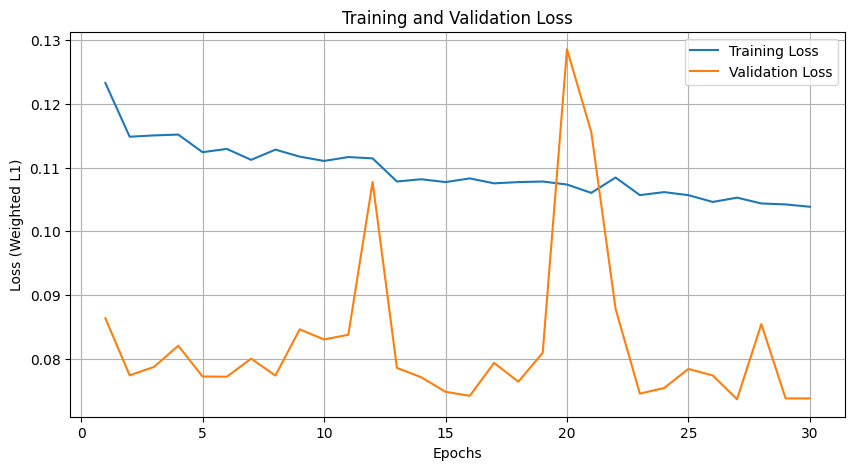

Best val loss:  0.07363961583801679


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Weighted L1)')
plt.legend()
plt.grid(True)
plt.savefig("training_loss_curve_improved.png")
plt.show()

print("Best val loss: ", best_val_loss)

In [ ]:
checkpoint = torch.load("resnet_colorizer.pth", map_location=device)
model.load_state_dict(checkpoint)

def calculate_metrics(model, loader, device):
    model.eval()
    total_psnr = 0.0
    total_ssim = 0.0
    count = 0

    with torch.no_grad():
        for L, ab in loader:
            L = L.to(device)
            ab = ab.to(device)

            pred_ab = model(L)

            real_ab = ab.cpu().numpy()
            pred_ab = pred_ab.cpu().numpy()

            for i in range(len(real_ab)):
                real_img = real_ab[i].transpose(1, 2, 0)
                pred_img = pred_ab[i].transpose(1, 2, 0)

                p = psnr(real_img, pred_img, data_range=2.0)
                s = ssim(real_img, pred_img, data_range=2.0, channel_axis=2)

                total_psnr += p
                total_ssim += s
                count += 1

    return total_psnr / count, total_ssim / count

avg_psnr, avg_ssim = calculate_metrics(model, test_loader, device)
print(f"Test Results: PSNR: {avg_psnr:.2f} dB | SSIM: {avg_ssim:.4f}")

Test Results: PSNR: 26.93 dB | SSIM: 0.3996


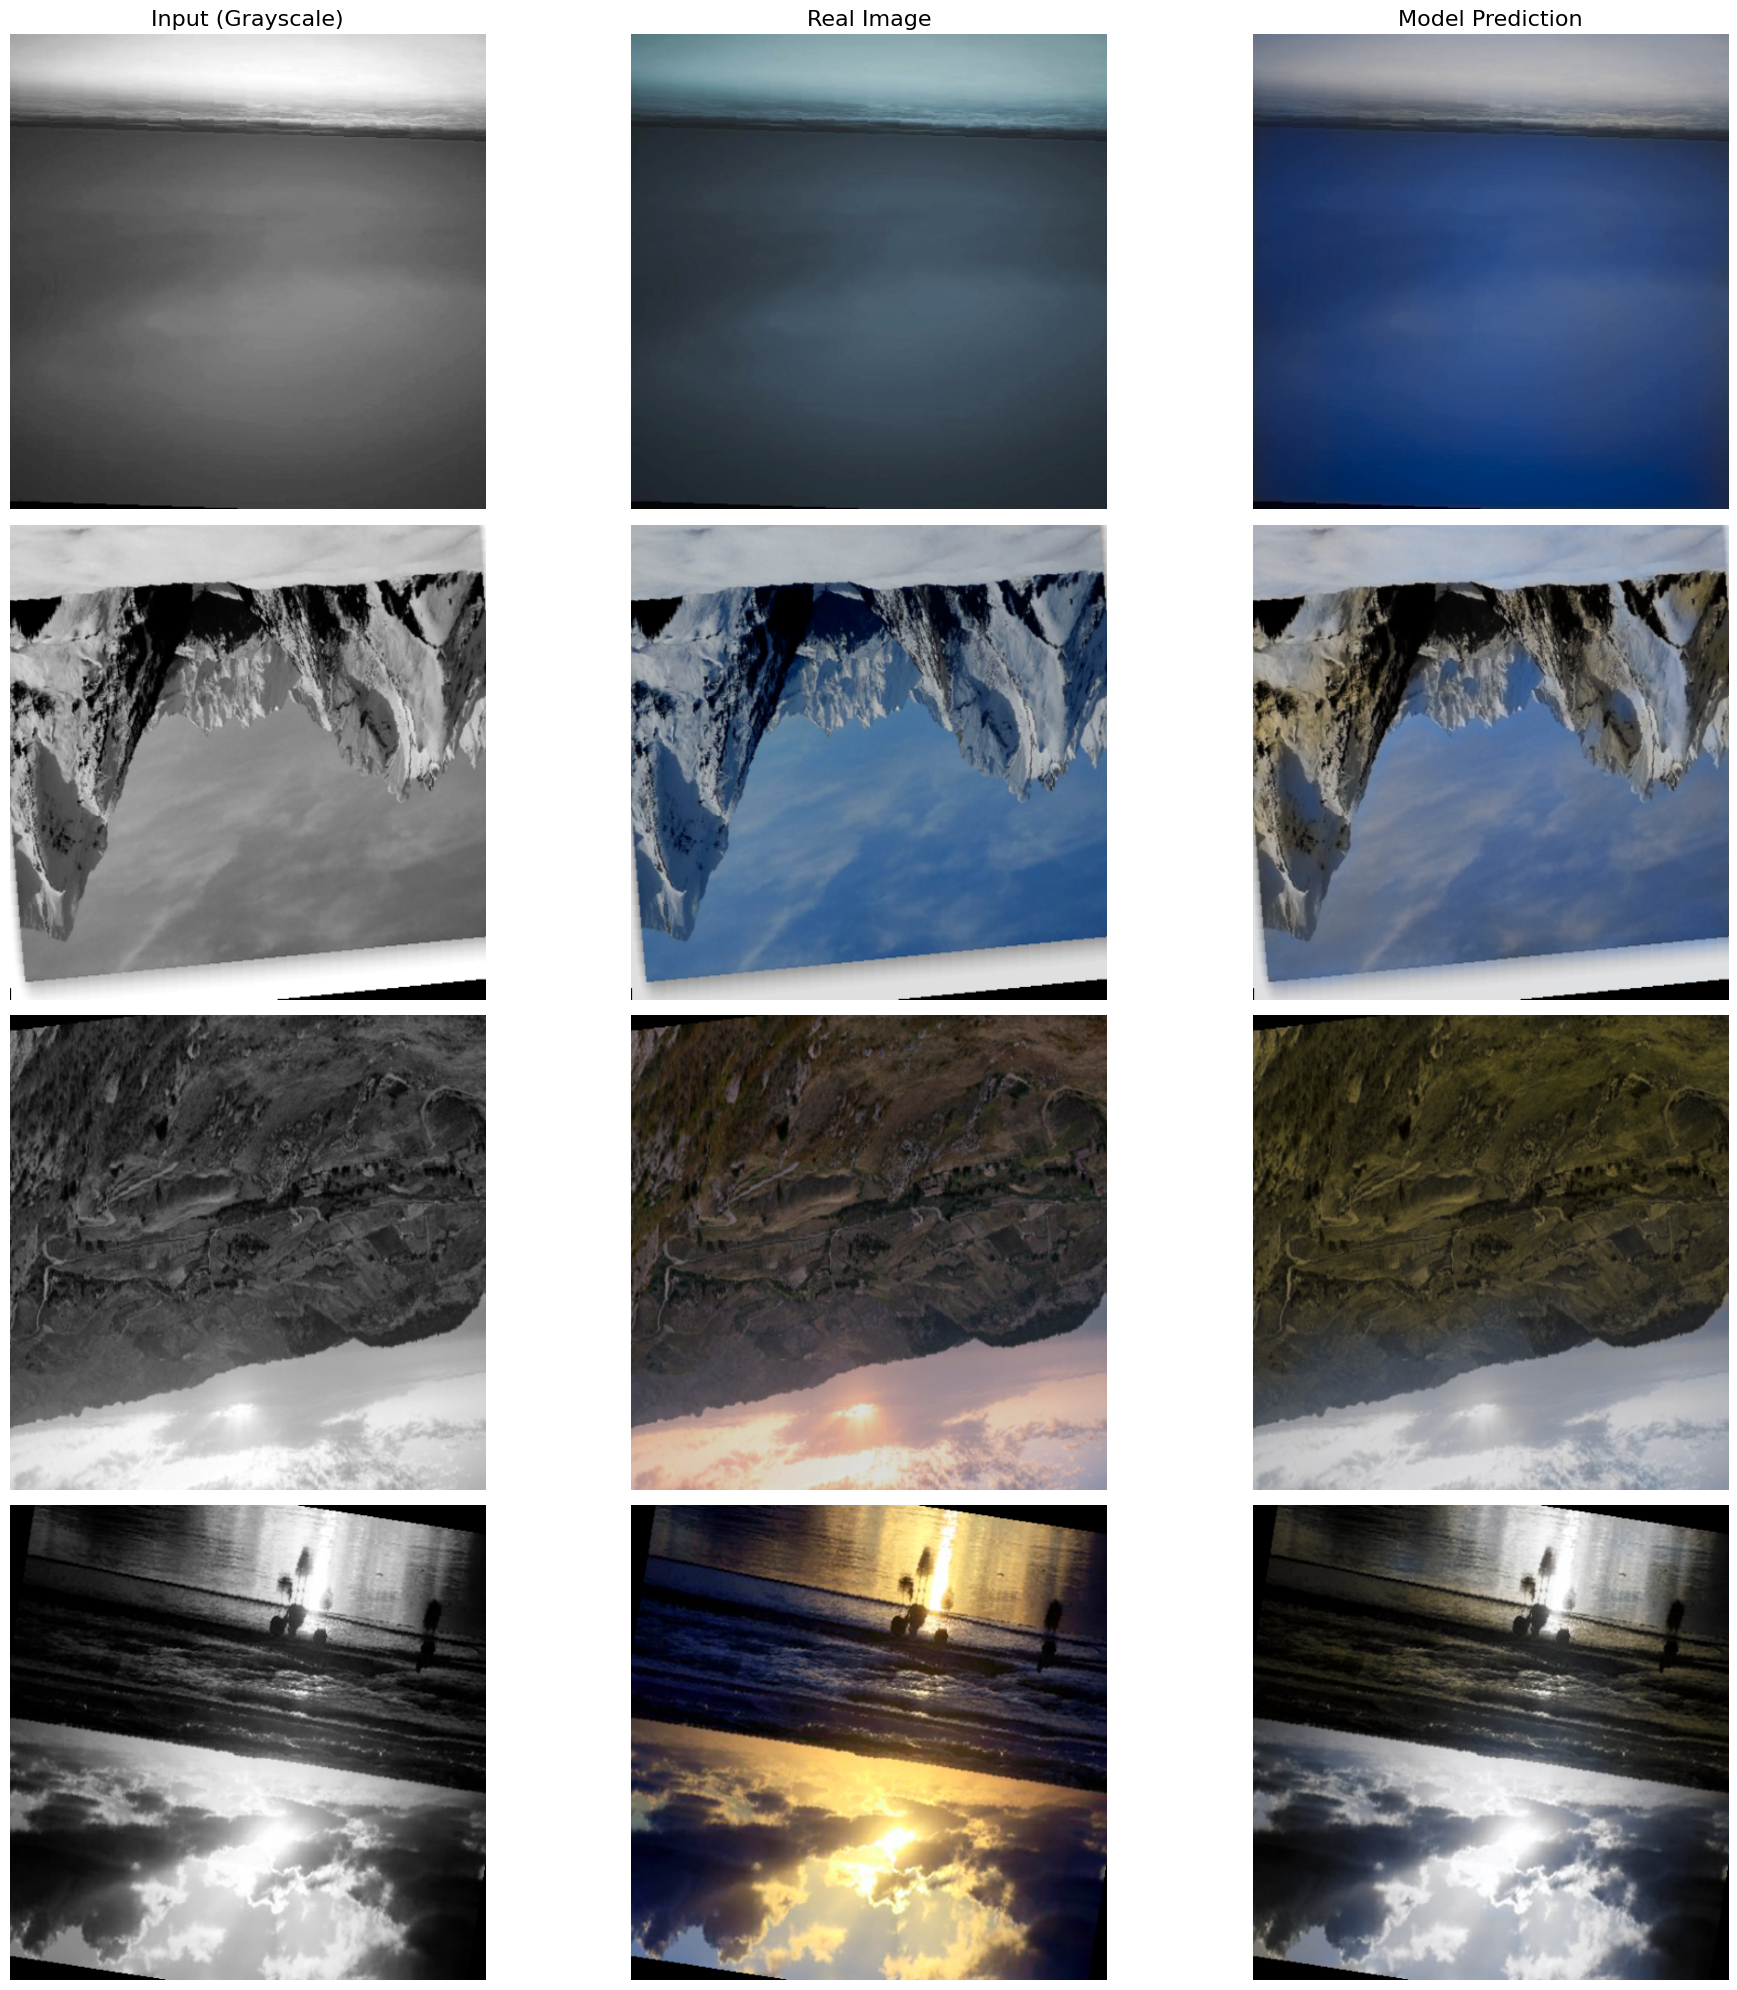

In [ ]:
data_iter = iter(test_loader)
L_test, ab_test = next(data_iter)
L_test = L_test.to(device)
ab_test = ab_test.to(device)

model.eval()
with torch.no_grad():
    ab_pred = model(L_test)

def tensor_to_rgb(L, ab):
    L = L.cpu().detach().numpy()
    ab = ab.cpu().detach().numpy()
    rgb_imgs = []

    for i in range(len(L)):
        img_L = L[i][0] * 100.0
        img_ab = ab[i] * 128.0

        h, w = img_L.shape
        lab_img = np.zeros((h, w, 3))
        lab_img[:, :, 0] = img_L
        lab_img[:, :, 1:] = img_ab.transpose(1, 2, 0)

        rgb_imgs.append(lab2rgb(lab_img))

    return np.array(rgb_imgs)

real_imgs = tensor_to_rgb(L_test, ab_test)
pred_imgs = tensor_to_rgb(L_test, ab_pred)

num_images = 4
fig, axes = plt.subplots(num_images, 3, figsize=(20, 20))
axes[0, 0].set_title("Input (Grayscale)", fontsize=16)
axes[0, 1].set_title("Real Image", fontsize=16)
axes[0, 2].set_title("Model Prediction", fontsize=16)

for i in range(num_images):
    axes[i, 0].imshow(L_test[i][0].cpu(), cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(real_imgs[i])
    axes[i, 1].axis('off')
    axes[i, 2].imshow(pred_imgs[i])
    axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig("test_results_improved.png")
plt.show()

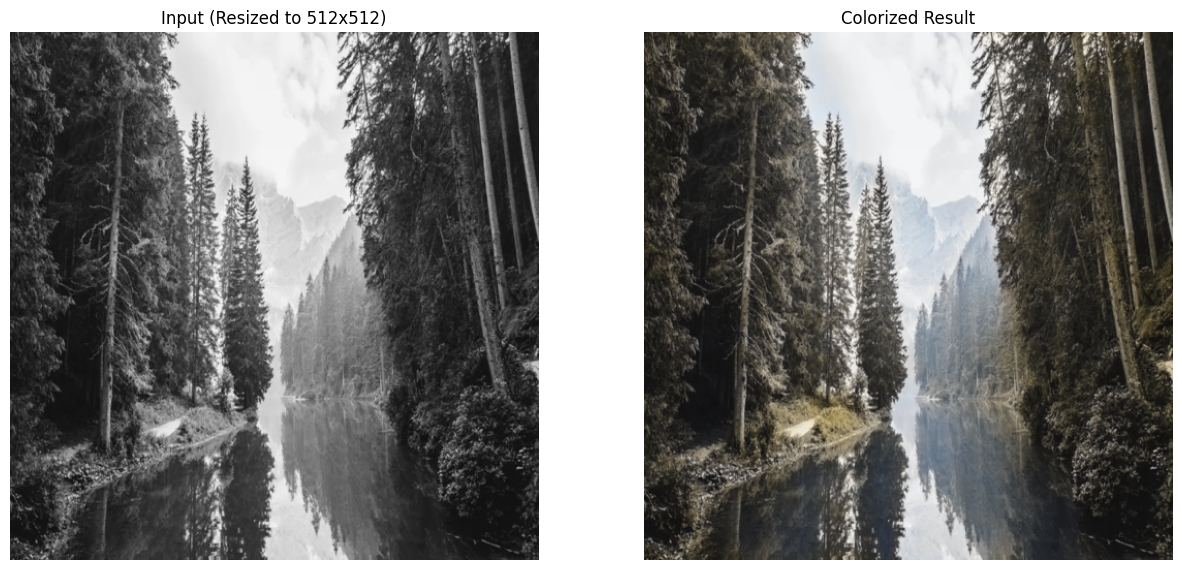

In [ ]:
INPUT_IMAGE_PATH = "testgambar15.jpg"

def predict_custom_image(image_path, model, device, target_size=512):
    img = Image.open(image_path).convert("RGB")

    transform = transforms.Compose([
        transforms.Resize((target_size, target_size)),
        transforms.Grayscale(num_output_channels=3)
    ])

    img_resized = transform(img)
    img_np = np.array(img_resized)

    img_lab = rgb2lab(img_np).astype("float32")
    L = img_lab[:, :, 0] / 100.0

    L_tensor = torch.from_numpy(L).unsqueeze(0).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        ab_pred = model(L_tensor)

    L = L_tensor.squeeze().cpu().numpy() * 100.0
    ab = ab_pred.squeeze().cpu().numpy() * 128.0

    lab_out = np.zeros((target_size, target_size, 3))
    lab_out[:, :, 0] = L
    lab_out[:, :, 1:] = ab.transpose(1, 2, 0)

    rgb_out = lab2rgb(lab_out)
    return img_resized, rgb_out

bw_input, color_output = predict_custom_image(INPUT_IMAGE_PATH, model, device, target_size=IMG_SIZE)

fig, axes = plt.subplots(1, 2, figsize=(15, 8))
axes[0].imshow(bw_input)
axes[0].set_title(f"Input (Resized to {IMG_SIZE}x{IMG_SIZE})")
axes[0].axis('off')

axes[1].imshow(color_output)
axes[1].set_title("Colorized Result")
axes[1].axis('off')

plt.show()

In [ ]:
# --- [SAVE FINAL MODEL] ---
torch.save({
    'epoch': NUM_EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
}, 'colorization_model.pth')

print("Improved model saved to colorization_model.pth")